In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns; sns.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, BatchNormalization, Dropout, MaxPool2D
from tqdm import tqdm
import time
import random

### **Pre-processing**

In [2]:
class_names = ['Arjun_Rampal', 'Arshad_Warsi', 'Asin', 'Ayushmann_Khurrana', 'Bhumi_Pednekar', 'Bipasha_Basu', 'Bobby_Deol', 'Deepika_Padukone', 'Disha_Patani', 'Emraan_Hashmi', 'Esha_Gupta', 'Farhan_Akhtar', 'Govinda']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}
nb_classes = len(class_names)
IMAGE_SIZE = (160, 160)

In [3]:
# read the input from MTCNN
data = np.load('data_bw.npz')
trainX,  trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

Loaded:  (1065, 160, 160, 3) (1065,) (452, 160, 160, 3) (452,)


In [4]:
n_train = trainy.shape[0]
n_test = testy.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each face is of size: {}".format(IMAGE_SIZE))

Number of training examples: 1065
Number of testing examples: 452
Each face is of size: (160, 160)


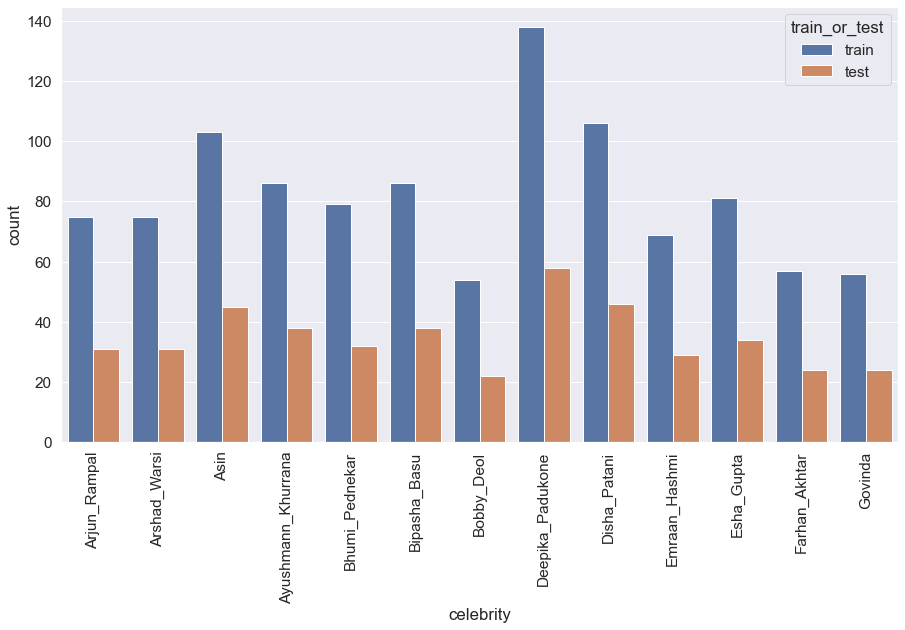

In [46]:
import pandas as pd
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(1, 1, 1)
_, train_counts = np.unique(trainy, return_counts=True)
_, test_counts = np.unique(testy, return_counts=True)
# pd.DataFrame({'train': train_counts,'test': test_counts}, index=class_names).plot.bar(ax=ax)
# res = pd.DataFrame({'train': train_counts,'test': test_counts}, index=class_names)
# res
res = pd.concat([pd.DataFrame(train_counts, index=class_names), pd.DataFrame(test_counts, index=class_names)])
res.columns = ['count']
res['train_or_test'] = np.array([1]*13 + [0]*13)
res['train_or_test'] = np.where(res['train_or_test'] == 1, 'train', 'test')
res.index.name = 'celebrity'
res.reset_index(drop=False, inplace=True)
sns.barplot(x='celebrity', y='count', hue='train_or_test', data=res)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
# plt.savefig("./figures/train_test.png", dpi=800) 

In [5]:
# standardization
trainX = trainX / 255
testX = testX / 255

In [6]:
# shuffle to make the validation set random
random.seed(4012)

trainX, trainy = shuffle(trainX, trainy, random_state=4012)

In [7]:
# thirteen classes in total
trainy

array(['Disha_Patani', 'Bhumi_Pednekar', 'Govinda', ..., 'Bhumi_Pednekar',
       'Emraan_Hashmi', 'Ayushmann_Khurrana'], dtype='<U18')

In [8]:
# display a random image
def display_random_image(class_names, images, labels):
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + labels[index])
    plt.show()

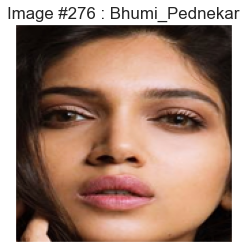

In [62]:
display_random_image(class_names, trainX, trainy)

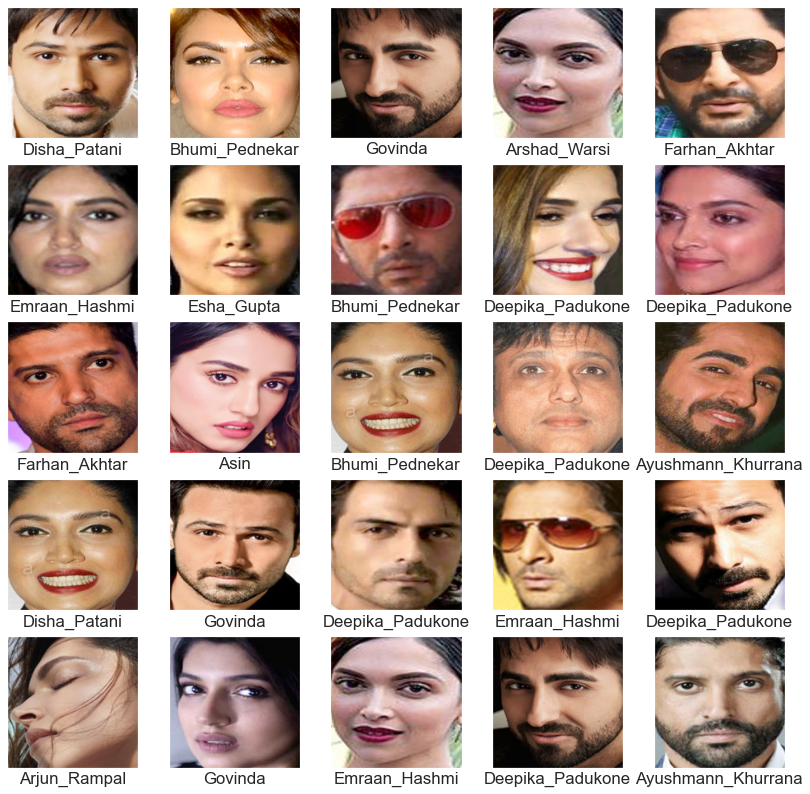

In [22]:
# display group of faces
def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(14,14))
    for i in range(25):
        index = np.random.randint(images.shape[0])
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[index], cmap=plt.cm.binary)
        # plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(labels[i])
    plt.savefig("./figures/correct2.png", dpi=600)
    plt.show()
display_examples(class_names, trainX, trainy)


In [8]:
# one-hot encoding
# perform one-hot encoding on train label
from sklearn.preprocessing import OneHotEncoder 
print(trainy.shape) #a list without second shape
print(trainy.reshape(-1, 1).shape) #change to a 2d array
encoder = OneHotEncoder()
trainy_hot = encoder.fit_transform(trainy.reshape(-1,1))
trainy_hot 
# trainy_hot is a sparse matrix, convert it to an ndarray
trainy_hot.toarray()

(1065,)
(1065, 1)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [9]:
# perform one hot encoding on test label
from sklearn.preprocessing import OneHotEncoder 
encoder = OneHotEncoder()
test_labels_hot = encoder.fit_transform(testy.reshape(-1,1))
test_labels_hot 
test_labels_hot.toarray()

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

### **CNN fitting**

#### **Model 1**

In [5]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (160, 160, 3)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(13, activation = "softmax"))
model.compile(optimizer='adam' , loss = "binary_crossentropy", metrics=["accuracy"])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 160, 160, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 160, 160, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 80, 80, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 80, 80, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 80, 80, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 80, 80, 64)        36928     
                                                        

In [10]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

tf.random.set_seed(4012)

# possible model 1
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (160, 160, 3)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(13, activation = "softmax"))
model.compile(optimizer='adam' , loss = "binary_crossentropy", metrics=["accuracy"])
history = model.fit(trainX, trainy_hot.toarray(), batch_size=64, epochs=50, validation_split = 0.2)


# model = Sequential()

# model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
#                  activation ='relu', input_shape = (160, 160, 3)))
# model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
#                  activation ='relu'))
# model.add(MaxPool2D(pool_size=(2,2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
#                  activation ='relu'))
# model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
#                  activation ='relu'))
# model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

# model.add(Dropout(0.25))
# model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
#                  activation ='relu'))
# model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
# model.add(Dropout(0.25))

# model.add(Flatten())
# model.add(Dense(256, activation = "relu"))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))
# model.add(Dense(32,activation="tanh"))
# model.add(BatchNormalization())
# model.add(Dense(13, activation = "softmax"))

# opt =  tf.keras.optimizers.Adagrad(learning_rate=0.05)
# model.compile(optimizer = 'adam', loss = "binary_crossentropy", metrics=["accuracy"])
# history = model.fit(trainX, trainy_hot.toarray(), batch_size=32, epochs=30, validation_split = 0.2)


learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                      patience=3, 
                      verbose=1, 
                      factor=0.7, 
                      min_lr=0.00000000001)

tf.random.set_seed(4012)


model = Sequential()

model.add(Conv2D(filters = 20, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (160,160,3)))

model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 50, kernel_size = (6,6),padding = 'Same', 
                 activation ='relu'))

model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 150, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (160,160,3)))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(13, activation = "softmax"))

model.compile(optimizer = 'adam', loss = "binary_crossentropy", metrics=["accuracy"])
history = model.fit(trainX, trainy_hot.toarray(), batch_size=32, epochs=100, validation_split = 0.2, callbacks=[learning_rate_reduction])

# # possible model 2
# model = Sequential()
# model.add(Conv2D(16,(3,3), padding= "SAME", input_shape = (160, 160, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))

# model.add(Conv2D(16,(3,3), padding= "SAME", input_shape = (160, 160, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))

# model.add(Conv2D(16,(3,3), padding= "SAME", input_shape = (160, 160, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))

# model.add(Flatten())
# model.add(Dense(64,activation="relu"))
# model.add(BatchNormalization())
# model.add(Dense(32,activation="tanh"))
# model.add(BatchNormalization())
# model.add(Dense(13,activation="softmax"))
# opt =  tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.0, decay=0.0, nesterov=False)

# model.compile(loss='binary_crossentropy', optimizer = opt, metrics= ['accuracy'])
# start_time = time.time()
# history = model.fit(trainX, trainy_hot.toarray(), batch_size=32, epochs=50, validation_split = 0.2)
# end_time = time.time()
# train_time = end_time - start_time

Epoch 1/100
27/27 [==============================] - 7s 142ms/step - loss: 0.7525 - accuracy: 0.1209 - val_loss: 0.8456 - val_accuracy: 0.0845 - lr: 0.0010
Epoch 2/100
27/27 [==============================] - 3s 93ms/step - loss: 0.6180 - accuracy: 0.1608 - val_loss: 0.7621 - val_accuracy: 0.1737 - lr: 0.0010
Epoch 3/100
27/27 [==============================] - 3s 94ms/step - loss: 0.4515 - accuracy: 0.2136 - val_loss: 0.3833 - val_accuracy: 0.1502 - lr: 0.0010
Epoch 4/100
27/27 [==============================] - 2s 92ms/step - loss: 0.3147 - accuracy: 0.3181 - val_loss: 1.0538 - val_accuracy: 0.1408 - lr: 0.0010
Epoch 5/100
27/27 [==============================] - ETA: 0s - loss: 0.2377 - accuracy: 0.4319
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.
27/27 [==============================] - 2s 92ms/step - loss: 0.2377 - accuracy: 0.4319 - val_loss: 0.7666 - val_accuracy: 0.1643 - lr: 0.0010
Epoch 6/100
27/27 [==============================] - 2s 92ms/step

In [11]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 160, 160, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 160, 160, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 80, 80, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 80, 80, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 80, 80, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 80, 80, 64)        36928     
                                                        

In [11]:
# evaluate on the test set
test_loss = model.evaluate(testX, test_labels_hot.toarray())
test_loss

15/15 [==============================] - 1s 37ms/step - loss: 0.1986 - accuracy: 0.5951


[0.19859525561332703, 0.5951327681541443]

In [14]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(18,5))

    # Plot accuracy
    plt.subplot(121)
    plt.plot(history.history['accuracy'],'bo--', label = "accuracy")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_accuracy")
    plt.title("train_accuracy vs val_accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(122)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")
    plt.subplots_adjust()
    plt.tight_layout()
    plt.legend()
    plt.show()

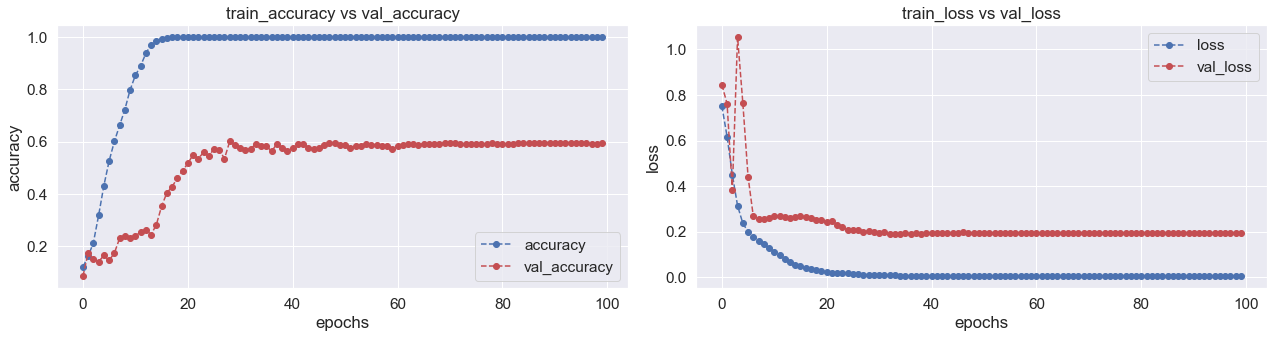

In [15]:
plot_accuracy_loss(history)

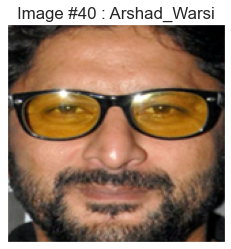

In [21]:
# define another randomly display function to visualize the result
def display_random_image2(class_names, images, labels):
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + labels[index])
    plt.show()

# convert the prediction result (in the format of 2d array) to the name of the celebrity (string)
predictions = np.round(model.predict(testX)).astype(int)    # Vector of probabilities
pred_labels = np.squeeze(predictions) 
pred = np.array([class_names[i.argmax()] for i in pred_labels])
display_random_image2(class_names, testX, pred)

In [22]:
predictions = np.round(model.predict(trainX)).astype(int)    # Vector of probabilities
train_labels = np.squeeze(predictions) 
train = np.array([class_names[i.argmax()] for i in train_labels])

In [23]:
pred[:5]

array(['Arjun_Rampal', 'Arjun_Rampal', 'Arjun_Rampal', 'Arjun_Rampal',
       'Arjun_Rampal'], dtype='<U18')

In [28]:
# randomly plot some mislabeled images
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Some examples of mislabeled images by the classifier:"
    display_examples(class_names,  mislabeled_images, mislabeled_labels)

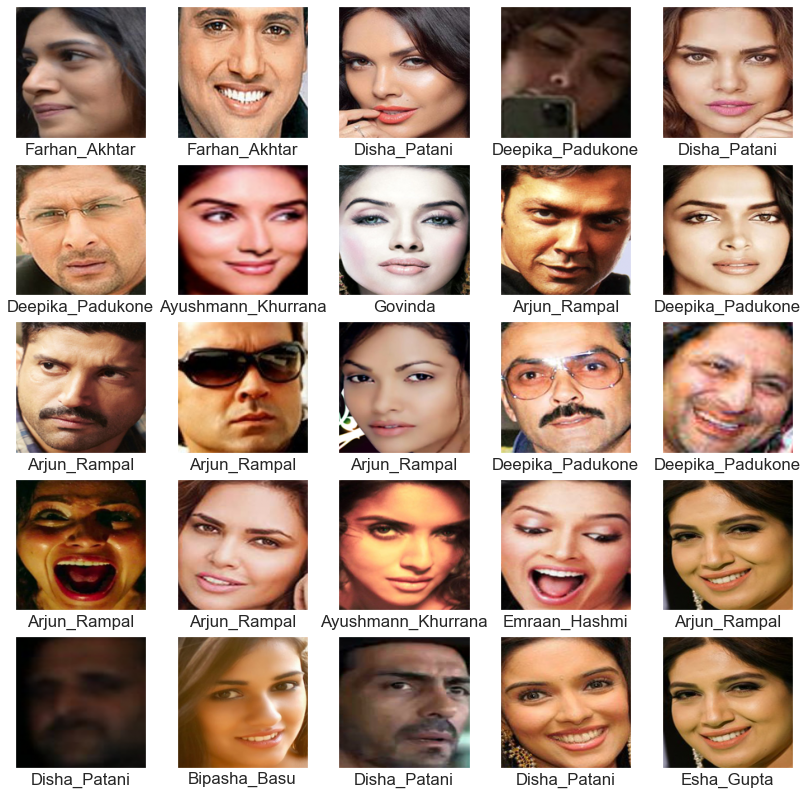

In [29]:
# print_mislabeled_images(class_names, trainX, trainy, train)
print_mislabeled_images(class_names, testX, testy, pred)

In [30]:
# calculate the confusion matrix
from sklearn.metrics import confusion_matrix
CM = confusion_matrix(testy, pred)
CM

array([[23,  0,  0,  1,  0,  0,  0,  2,  2,  0,  0,  2,  1],
       [ 7, 19,  0,  1,  0,  0,  0,  3,  0,  1,  0,  0,  0],
       [13,  0, 17,  0,  0,  2,  0,  5,  7,  0,  1,  0,  0],
       [10,  0,  1, 23,  0,  0,  0,  1,  0,  3,  0,  0,  0],
       [ 3,  0,  1,  0, 22,  1,  0,  2,  0,  0,  3,  0,  0],
       [ 6,  0,  1,  0,  1, 21,  0,  1,  5,  0,  3,  0,  0],
       [ 5,  1,  0,  0,  0,  0,  6,  1,  0,  1,  3,  2,  3],
       [ 7,  0,  3,  0,  0,  1,  1, 40,  1,  0,  4,  1,  0],
       [ 4,  1,  1,  0,  0,  2,  1,  3, 30,  0,  4,  0,  0],
       [ 6,  1,  0,  3,  0,  0,  0,  0,  0, 18,  0,  1,  0],
       [11,  0,  0,  0,  0,  0,  0,  8,  1,  1, 13,  0,  0],
       [ 5,  1,  0,  0,  2,  0,  0,  1,  0,  0,  1, 13,  1],
       [ 6,  0,  1,  2,  1,  1,  1,  0,  0,  0,  1,  0, 11]], dtype=int64)

In [31]:
from sklearn.metrics import classification_report
print(classification_report(testy, pred, target_names=class_names))

                    precision    recall  f1-score   support

      Arjun_Rampal       0.22      0.74      0.34        31
      Arshad_Warsi       0.83      0.61      0.70        31
              Asin       0.68      0.38      0.49        45
Ayushmann_Khurrana       0.77      0.61      0.68        38
    Bhumi_Pednekar       0.85      0.69      0.76        32
      Bipasha_Basu       0.75      0.55      0.64        38
        Bobby_Deol       0.67      0.27      0.39        22
  Deepika_Padukone       0.60      0.69      0.64        58
      Disha_Patani       0.65      0.65      0.65        46
     Emraan_Hashmi       0.75      0.62      0.68        29
        Esha_Gupta       0.39      0.38      0.39        34
     Farhan_Akhtar       0.68      0.54      0.60        24
           Govinda       0.69      0.46      0.55        24

          accuracy                           0.57       452
         macro avg       0.66      0.55      0.58       452
      weighted avg       0.65      0.5

In [30]:
confusion_matrix(trainy, train)

array([[ 65,   0,   0,   2,   0,   0,   2,   1,   1,   1,   2,   0,   1],
       [  2,  68,   0,   0,   1,   1,   0,   0,   0,   1,   0,   1,   1],
       [  0,   0,  89,   0,   1,   2,   2,   3,   4,   0,   1,   0,   1],
       [  3,   1,   0,  75,   2,   1,   0,   0,   3,   0,   0,   0,   1],
       [  0,   0,   0,   0,  71,   3,   0,   0,   0,   0,   4,   0,   1],
       [  0,   0,   0,   0,   1,  82,   1,   0,   1,   0,   1,   0,   0],
       [  1,   0,   0,   1,   0,   0,  48,   1,   0,   1,   0,   0,   2],
       [  1,   1,   2,   1,   1,   1,   2, 122,   4,   0,   3,   0,   0],
       [  2,   0,   2,   0,   0,   5,   0,   1,  96,   0,   0,   0,   0],
       [  1,   1,   1,   3,   0,   0,   0,   0,   0,  62,   0,   1,   0],
       [  1,   0,   1,   0,   3,   1,   0,   1,   0,   0,  74,   0,   0],
       [  0,   1,   0,   1,   2,   1,   0,   0,   0,   0,   0,  52,   0],
       [  0,   0,   0,   0,   0,   0,   0,   2,   0,   1,   0,   1,  52]],
      dtype=int64)

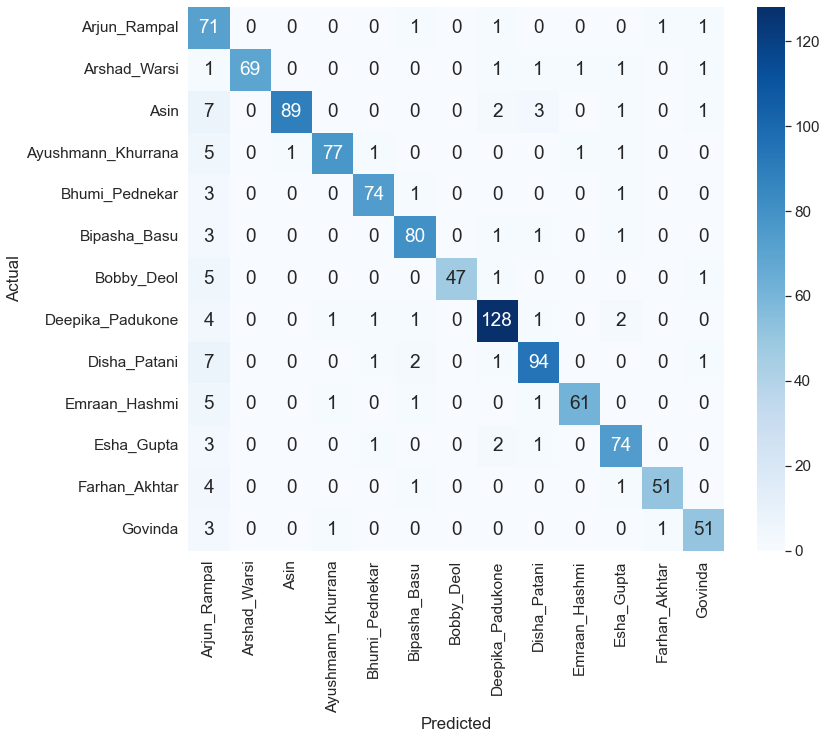

In [37]:
# plot the confusion matrix
# data = confusion_matrix(trainy, train)
data = confusion_matrix(testy, pred)
df_cm = pd.DataFrame(data, columns=np.unique(testy), index = np.unique(testy))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (12, 10))
# sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True, fmt='d', annot_kws={"size": 19}) 
# sns.heatmap(df_cm, annot=True) 
# plt.savefig("./figures/cnn2_confusion_train.png", dpi=800) 